In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [2]:
!pip install elasticdeform
!pip install "torch==1.4" "torchvision==0.5.0"

  Created wheel for elasticdeform: filename=elasticdeform-0.4.6-cp36-cp36m-linux_x86_64.whl size=70442 sha256=1ab4d05dc08244c59cd8629ef9e0270dc231128535142ca46f7157ccdf4b4cd7
  Stored in directory: /root/.cache/pip/wheels/42/3a/94/a1d69f8b9da44826a171395e67f9f7a117f89af18f206481dd
Successfully built elasticdeform
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 45.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
%tensorflow_version 1.x

import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from torch import nn
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold, KFold

from fastai.callbacks import *

from datetime import datetime
from ipywidgets import widgets

from deepflash import preproc, unetadaption, utility
from deepflash.fastai_extension import *

TensorFlow 1.x selected.


Using TensorFlow backend.


## Settings

Load a previous model ('yymmdd-HHMM' format) or set to None

In [0]:
LOAD_MODEL = None   # str: model name
STAGE = None        # int: execute stage 0,1,2

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'

IMAGE_TYPE = 'L'    # 'L' for greyscale, 'RGB'for color, 'P' for palette images

TILE_SHAPE = (540,540)    # desired input size (e.g. (540,540))
MASK_SHAPE = (356,356)       # Check 'Custom Net Overview' section for last layer output shape
EL_SIZE = [635.9, 635.9]

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/red'
MASK_PATH = f'{DIR}/temp_data/labels/'
WEIGHT_PATH = f'{DIR}/temp_data/weights/'

# DON'T CHANGE
PADDING = tuple(np.subtract(TILE_SHAPE,MASK_SHAPE))

Training Params

In [0]:
BATCH_SIZE = 8
N_SPLITS = 10
WEIGHT_DECAY = 0.0005
INITIAL_KFOLD = False   # trials show that an initial k-fold does not seem to be necessary

CSV_LOG = True          # logs error and loss in a seperate CSV file

Network Params

In [0]:
IN_CHANNELS = 1 #dependant on IMAGE_TYPE : 1 if 'L' or 'P', 3 if 'RGB'
N_CLASSES = 2  #number of classes
DEPTH = 5
BATCH_NORM = True #batch normalization after first layer

In [0]:
def split_net(model):
  return list(model.children())

# Custom Net Overview

In [10]:
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,
                        n_classes=N_CLASSES,
                        depth=DEPTH,
                        batch_norm=BATCH_NORM)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
       BatchNorm2d-8        [-1, 128, 266, 266]             256
            Conv2d-9        [-1, 128, 264, 264]         147,584
             ReLU-10        [-1, 128, 264, 264]               0
      BatchNorm2d-11        [-1, 128, 264, 264]             256
    UNetConvBlock-12        [-1, 128, 264, 264]               0
           Conv2d-13        [-1, 256, 130, 130]         295,168
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] # get list with img_ids
imgExt = os.path.splitext(filenames[0])[1]                    # get image extension

In [0]:
images = [img_name for img_name in [f'{s}{imgExt}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### Change regDigits if filenames have a different structure

regDigits = '\d{4}'
maskExt = '.tif'
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')

Show example image, labels and weights

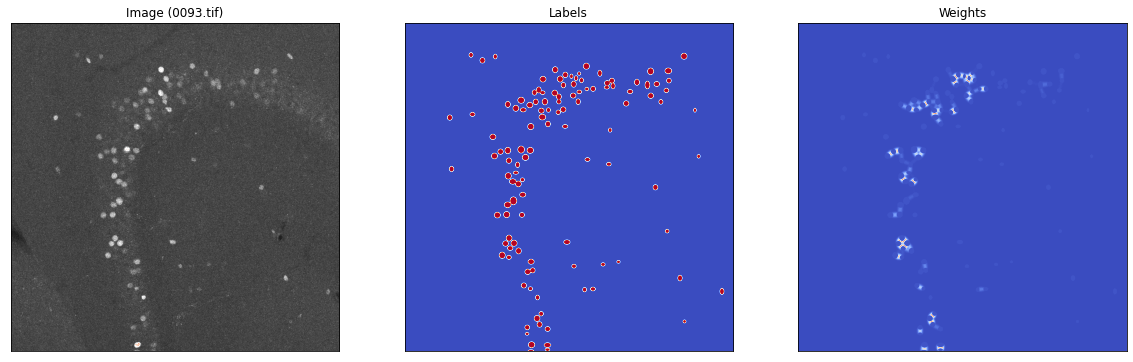

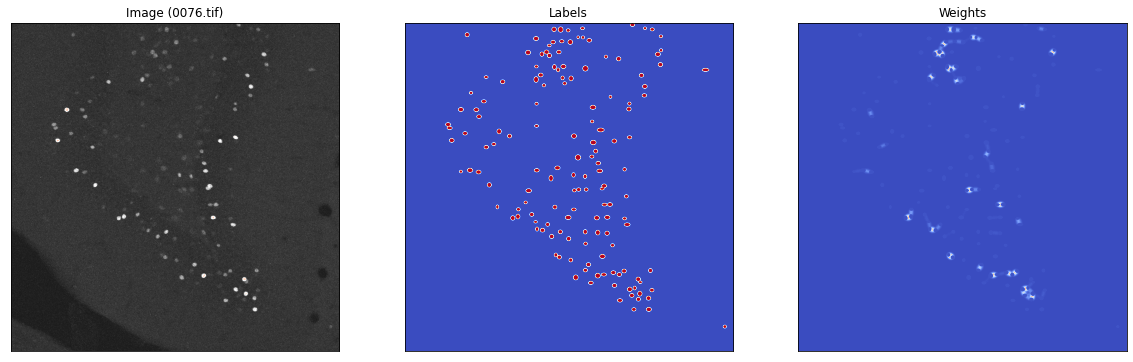

In [14]:
# cmap can be either string or list of strings
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights,cmap=('RdGy_r','coolwarm','coolwarm'), n=2)

# Data Preparation

**Data Augmentation** <br>SETTINGS<br>Change augmentation params here

In [0]:
DEFORMATION = True    #elastic deformation with magnitude SIGMA and number ob gridpoints GRID_DIVS
SIGMA = 6
GRID_DIVS = 6

RAND_CROP = True    #random crop of image

ROTATION_MAX_ANGLE = 10     #max rotation in degrees

LIGHT_CONTRAST_CHANGE = 0.01    #max increase of brightness/contrast

TRANSFORM_VALID = True    #also transform validation dataset

xtra_tfms = None  #add extra transforms as list here, e.g. xtra_tfms = [jitter()]

Calculate the range of center coordinates for random crop

In [0]:
# gets original size of raw images
original_size = utility.get_image_size(f'{IMG_PATH}/{img_ids[0]}{imgExt}')

# min distance from any border of the image in percent (tuple for x and y):
row_col_per = np.divide(np.add(np.multiply(0.5,TILE_SHAPE),1),original_size)

# ranges for row_pct and col_pct for initial_crop_pad(**rand_pos):
rand_pos = {'row_pct':(row_col_per[0],1-row_col_per[0]), 'col_pct':(row_col_per[1],1-row_col_per[1])}

Visualization of deformation grid

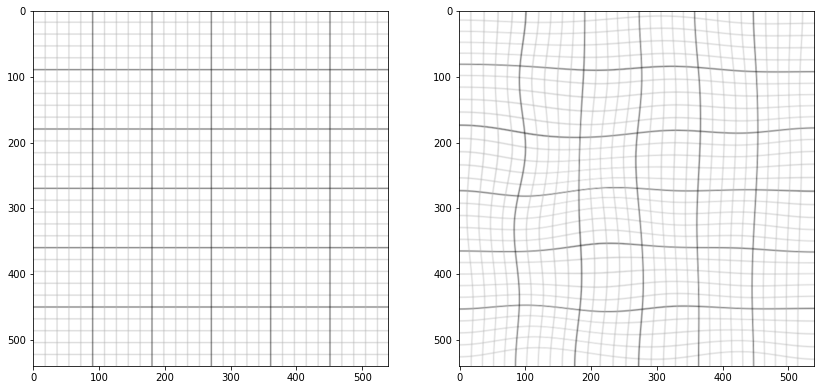

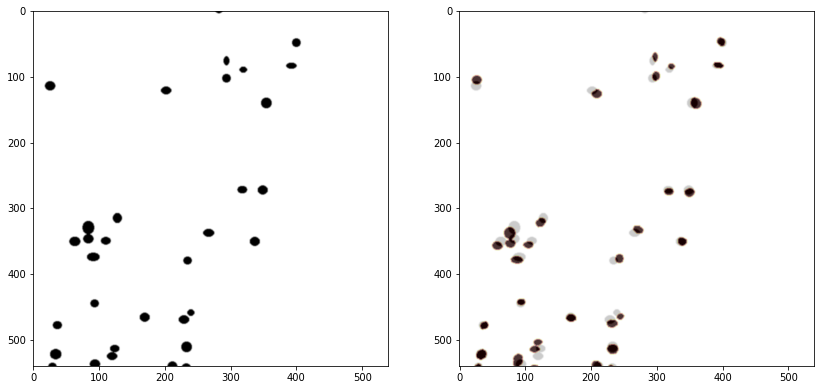

In [17]:
example_img = io.imread(get_labels(img_ids[2]))

utility.test_deformation(shape=TILE_SHAPE,sigma=SIGMA,points=GRID_DIVS)
utility.test_deformation(shape=TILE_SHAPE,example_img=example_img, sigma=SIGMA,points=GRID_DIVS)

**Custom 'get_transforms()' function for selected augmentations**

Transforms are generally applied on train set only, but this can be changed with 'transform_valid_ds = True'. Standard transforms on train set include: 

*   randomly mirror image on x- and y-axis
*   light brightness and contrast shift
*   random rotation
*   elastic deformation





In [0]:
tfms = get_custom_transforms(elastic_deformation= DEFORMATION,
                             elastic_deform_args= {'sigma':SIGMA, 'points':GRID_DIVS},
                             random_crop= TILE_SHAPE if RAND_CROP else None,
                             rand_pos= rand_pos, 
                             max_lighting= LIGHT_CONTRAST_CHANGE,
                             max_rotate= ROTATION_MAX_ANGLE,
                             transform_valid_ds= TRANSFORM_VALID,
                             xtra_tfms = xtra_tfms
                             )

**Create databunch object**

In [19]:
data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      # import from df in grayscale
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 random train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True)
      # apply data augmentation
      .databunch(bs=BATCH_SIZE)
      # set batchsize
)

Masks will be cropped to (356, 356). Choose 'None' to keep initial size.
Masks will be cropped to (356, 356). Choose 'None' to keep initial size.


In [20]:
data.show_batch()

Output hidden; open in https://colab.research.google.com to view.

## Learner object and Training

In [0]:
# set foldername for this training as datetime in yymmdd-hhmm-format
run_folder = datetime.today().strftime('%y%m%d-%H%M')

if LOAD_MODEL:
  run_folder = LOAD_MODEL

Metrics

In [0]:
# metrics_wrapper let's you use any metric for this weighted-labels architecture 
# (get's rid of the weights and passes only labels to metric)
# if 'swap_preds = True' prediction and groundtruth are swapped (useful for sklearn.metrics)
# if 'softmax = True' all predictions will be normalized using nn.Softmax2d

IoU = metrics_wrapper(metric=dice, iou=True)
f1 = metrics_wrapper(metric=fbeta, beta=1) ##Ignore class 0, argmax result of softmax or round
foreground = metrics_wrapper(metric=foreground_acc, void_code=0)

metrics = [IoU,f1,foreground]

Callbacks

In [0]:
# Callback function to save best learner object during training with model name 'name'.
# Metric can be changed to whatever metric should be primarily monitored.
# For more on this:
# https://docs.fast.ai/callbacks.tracker.html#SaveModelCallback

def custom_callbacks(learner, name, metric='dice'):
  callbacks = [SaveModelCallback(learner, every='improvement', monitor=metric, name=name)]
  return callbacks

Learner <br>
<p><i>Initiation of the learner object. This will be called anytime a training cycle is started. This function can be customized for any values that should be passed into 'learner'. Models are saved in an individual datetime folder like this</i> "./model/yymmdd-HHMM". If a model should be loaded this folder is called here.</P>

In [0]:
def initiate_learner(folder, csv_log:bool=CSV_LOG, filename:str='history'):

  learn = Learner(data, 
                  net,
                  model_dir = f'{DIR}/model/{folder}',
                  opt_func = torch.optim.Adam,
                  metrics = metrics,
                  loss_func = WeightedCrossEntropyLoss(axis=1, reduction_mode='mean'),
                  wd = WEIGHT_DECAY,
                  callback_fns=[ShowGraph, partial(CSVLogger, filename=f'{DIR}/model/{folder}/{filename}')] if csv_log else [ShowGraph])
  return learn

In [0]:
learn = initiate_learner(run_folder, filename = 'initiation_stage')

Learning Rate Finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


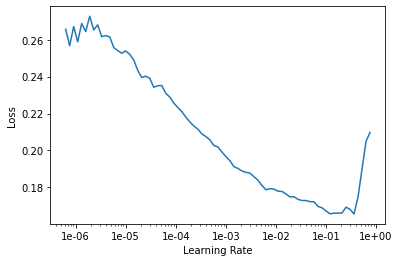

In [26]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [27]:
MAX_LEARNING_RATE = utility.chose_lr()

# for initial training, a higher number of epochs should be used (>50)
INITIAL_EPOCHS = utility.chose_n_epochs()

Chose learning rate (e.g. 1e-04): 
1e-02
Number of training epochs: 
100


**Initial Training Cycle**

In [0]:
#save initiation weights
learn.save('initiation_stage')

In [0]:
# initiate kfold
kfold = KFold(N_SPLITS, True, SEED)

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.184546,0.239024,0.000000,0.029377,0.000000,00:20
1,0.162714,0.243653,0.000000,0.032189,0.000000,00:14
2,0.157568,0.312222,0.000000,0.035451,0.000000,00:13
3,0.150767,0.261591,0.000141,0.031811,0.000331,00:14
4,0.144196,0.282273,0.024169,0.032487,0.273748,00:13
5,0.140658,0.940647,0.024644,0.032859,1.000000,00:14
6,0.137321,0.231804,0.025852,0.035868,0.347184,00:19
7,0.131380,1.595627,0.025741,0.034322,1.000000,00:14
8,0.128717,0.150489,0.038975,0.035342,0.130581,00:13
9,0.125820,0.154923,0.022113,0.037359,0.113301,00:13


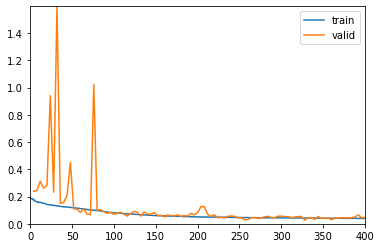

Better model found at epoch 0 with dice value: 0.0.
Better model found at epoch 3 with dice value: 0.00014072615886107087.
Better model found at epoch 4 with dice value: 0.024169376119971275.
Better model found at epoch 5 with dice value: 0.024644404649734497.
Better model found at epoch 6 with dice value: 0.025851523503661156.
Better model found at epoch 8 with dice value: 0.03897496312856674.
Better model found at epoch 10 with dice value: 0.04435206949710846.
Better model found at epoch 14 with dice value: 0.2271283119916916.
Better model found at epoch 20 with dice value: 0.3264356851577759.
Better model found at epoch 21 with dice value: 0.3875213861465454.
Better model found at epoch 28 with dice value: 0.3907753527164459.
Better model found at epoch 45 with dice value: 0.4125145375728607.
Better model found at epoch 55 with dice value: 0.43325257301330566.
Better model found at epoch 62 with dice value: 0.5089253187179565.
Better model found at epoch 66 with dice value: 0.539065

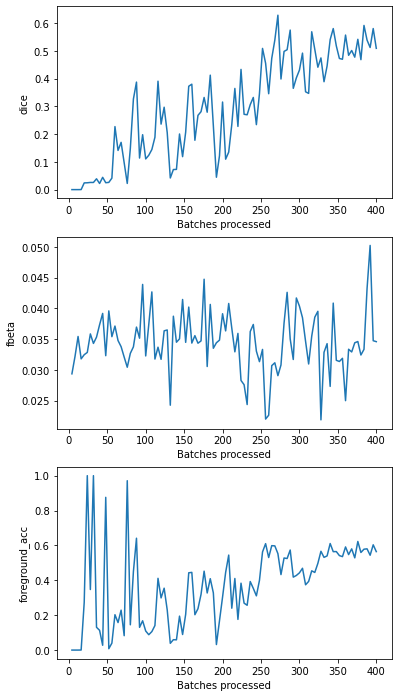

In [30]:
# if kfold for first run
if INITIAL_KFOLD:

  count = 0
  for train, test in kfold.split(img_df):
    
    #load initiation weights
    utility.blockPrint()
    learn = initiate_learner(run_folder,filename = f'initial_stage_{count}')
    learn.load(f'initiation_stage')

    #load data for this fold
    data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
        .split_by_idxs(train_idx=train, valid_idx=test)
        .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
        .transform(tfms=tfms, tfm_y=True)
        .databunch(bs=BATCH_SIZE)
    )
    utility.enablePrint()

    #change train and valid data
    learn.data = data

    learn.fit_one_cycle(INITIAL_EPOCHS,
                        max_lr=MAX_LEARNING_RATE,
                        callbacks=custom_callbacks(learn,f'best_initial_stage_{count}'))
    
    learn.recorder.plot_metrics()

    learn.purge()
    learn.destroy()

    count += 1

else:
  learn.load('initiation_stage')

  learn.fit_one_cycle(INITIAL_EPOCHS,
                      max_lr=MAX_LEARNING_RATE,
                      callbacks=custom_callbacks(learn,'initial_stage-best_fold'))

  learn.save('initial_stage-final_epoch')

  learn.recorder.plot_metrics()

  learn.purge()
  learn.destroy()

**Second Training Cycle with KFold** <br>
This cycle is meant for fine tuning using a very low learning rate to train feature detection even further

In [0]:
learn = initiate_learner(run_folder)

CHOSE best fold if initial training was done with kfold cross-validation


In [0]:
# if there was an initial kfold, load best fold

if INITIAL_KFOLD:
  
  BEST_FOLD = utility.chose_fold()
  stage_name = f'best_initial_stage_{BEST_FOLD}'

  learn.load(stage_name)

  learn.save('initial_stage-best_fold')

#otherwise load single fold
else:
  stage_name = 'initial_stage-best_fold'
  learn.load(stage_name)

utility.blockPrint()
learn.load(stage_name)
utility.enablePrint()

Learning Rate Finder

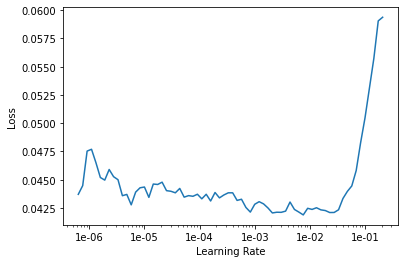

In [33]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [0]:
# CHOSE best learning rate and number of training epochs
LEARNING_RATE = utility.chose_lr()
TRAIN_EPOCHS = utility.chose_n_epochs() # usually around 10-15

Train

In [0]:
count = 0

# enumerate splits
for train, test in kfold.split(img_df):

  # set name of fold
  fold_name = f'stage1-kfold-{count}'
  
  utility.blockPrint()
  learn = initiate_learner(run_folder,filename=fold_name)
  learn.load(stage_name)

  #load data for this fold
  data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      .split_by_idxs(train_idx=train, valid_idx=test)
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      .transform(tfms=tfms, tfm_y=True)
      .databunch(bs=BATCH_SIZE)
  )
  utility.enablePrint()

  # swap data of Leaner
  learn.data = data

  # train
  learn.fit_one_cycle(TRAIN_EPOCHS,
                      wd=WEIGHT_DECAY, 
                      max_lr = LEARNING_RATE,
                      callbacks=custom_callbacks(learn,f'best_{fold_name}'))

  # save and destroy learner
  learn.purge()
  learn.destroy()

  count += 1  

**Third Training Cycle with Freeze** <br>
This training cycle is used to train the last layer of our network.

In [0]:
# initiate learner
learn = initiate_learner(run_folder,filename='stage2')

CHOSE best fold from Second Training Cycle

In [0]:
BEST_FOLD = utility.chose_fold()

In [0]:
utility.blockPrint()

# either load a best fold or save current best fold
if LOAD_MODEL and STAGE == 2:
  stage_name = 'stage1-best_fold'
  learn.load(stage_name)

else:
  stage_name = f'best_stage1-kfold-{BEST_FOLD}'
  learn.load(stage_name)
  learn.split(split_net)

  learn.freeze()

  learn.save('stage1-best_fold')

#learn.split(split_net)

utility.enablePrint()

Learning Rate Finder

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# CHOSE best learning rate and number of training epochs
LEARNING_RATE = utility.chose_lr()
TRAIN_EPOCHS = utility.chose_n_epochs()

Train

In [0]:
count = 0

# enumerate splits
for train, test in kfold.split(img_df):

  # set name of fold
  fold_name = f'stage2-kfold-{count}'

  # initiate learner
  utility.blockPrint()
  learn = initiate_learner(run_folder, filename=fold_name)
  learn.load('stage1-best_fold')

  #load data for this fold
  data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      .split_by_idxs(train_idx=train, valid_idx=test)
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      .transform(tfms=tfms, tfm_y=True)
      .databunch(bs=BATCH_SIZE)
  )
  utility.enablePrint()

  # swap data of Leaner
  learn.data = data

  # train
  learn.fit_one_cycle(TRAIN_EPOCHS,
                      wd=WEIGHT_DECAY, 
                      max_lr = LEARNING_RATE,
                      callbacks=custom_callbacks(learn,f'best_{fold_name}'))

  # save and destroy learner
  learn.save(fold_name)
  learn.purge()
  learn.destroy()

  count += 1  

CHOOSE best fold

In [0]:
BEST_FOLD = utility.chose_fold()

In [0]:
utility.blockPrint()

# initiate learner
learn = initiate_learner(run_folder)


stage_name = f'best_stage2-kfold-{BEST_FOLD}'
learn.load(stage_name)
learn.save('final_weights')

utility.enablePrint()

In [0]:
learn.export(f'{DIR}/model/{run_folder}/final_model.pkl')